## Problem Statement

#### To develop a machine learning model to predict whether a free plan user would convert to a paid subscriber or not.

We have engagement data and subscription information for users of 365DataScience from 1st of Jan to 20th October 2022. Using this engagement data and subscription information (paid/free). we should develop a model that can predict if a new free user will pay and subscribe or not.

Features of interest are already extracted via SQL manipulation of interaction data (file attached). Moving to python, we will perform following steps - 

- Further exploratory data analysis or feature engineering (dimension reduction and standardization etc.)
- Train and Test split
- Balance the classes in case of imbalance
- Application of various models and method to analyze the best performance.

#### How to evaluate best performing model?

The (assumed) business purpose is to target and send customized offers to potential upgraders to convert to paid subscription. In that context, we should develop a model that minimizes false negatives since we dont want to miss opportunity to reach any perspective upgraders. Given focus on false negatives, its best to **pick a model with best RECALL.**

![Business impact of confusion metrix](conf.jpg)

## Importing Required Libraries

In [26]:
# Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

# Data balancing combining over and under sampling
from imblearn.combine import SMOTETomek

# Grid search for hyper parameter tuning and CV
from sklearn.model_selection import GridSearchCV

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# Histogram Gradient Boosting
from sklearn.ensemble import HistGradientBoostingClassifier

# accuracy metrics
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, classification_report, accuracy_score, plot_roc_curve, plot_precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

## Loading Data

In [2]:
# The relevent features are already extracted using SQL manipulation from the interaction data.
raw_data = pd.read_csv('365_feature_data.csv')
data = raw_data.copy()
data.head()

,student_id,student_country,date_registered,first_date_purchased,mins_watched_14d,quiz_engagements_14d,exams_engagements_14d,lessons_engagements_14d,course_ratings_14d,hub_questions_14d,reg_status
0,258798,IN,2022-01-01,NaN,0.3,0,0,1,0.0,0,0
1,258799,CO,2022-01-01,NaN,0.0,0,0,0,0.0,0,0
2,258800,CA,2022-01-01,2022-01-01,268.4,6,3,10,0.0,0,1
3,258801,IN,2022-01-01,NaN,0.0,0,0,0,0.0,0,0
4,258802,US,2022-01-01,NaN,0.0,0,0,0,0.0,0,0


We have a list of students (**student_id**) togather with their country (**student_country**) and registration date (**date_registered**) and purchase date (**date_purchased**) if they made subscription purchase. Apart from this metadata, we have following features that we think will be useful for subscription prediction - 

- **mins_watched_14d** - Totals mins of course video watched by students in first 14 days of registration.
- **quiz_engagements_14d** - Number of quizes students engaged in first 14 days of registration.
- **exams_engagements_14d** - Number of exams students engaged with in first 14 days of registration.
- **lessons_engagements_14d** - Number of lessons students engaged with in first 14 days of registration.
- **course_ratings_14d** - average of all course ratings given (0 - 5) in first 14 days of registrations.
- **hub_questions_14d** - number of hub questions asked in first 14 days of registartion

Our Target variable is **reg_status** which is 0 if the students have never purchased and 1 if they have ever purchased paid subscription.
Note: students can purchase multiple subscriptions in the time period if the previous one's get expired. They can also keep changing their status from free to paid multiple timee. We have left that out of scope in the current problem statement and are considering only the first purchase as turning point from free to paid.

## EDA and Feature Engineering

In [3]:
# isolating the features that will be used for modelling
# all the choosen features are numerical
features = data.drop(columns=['reg_status','student_id','student_country','date_registered','first_date_purchased']).columns

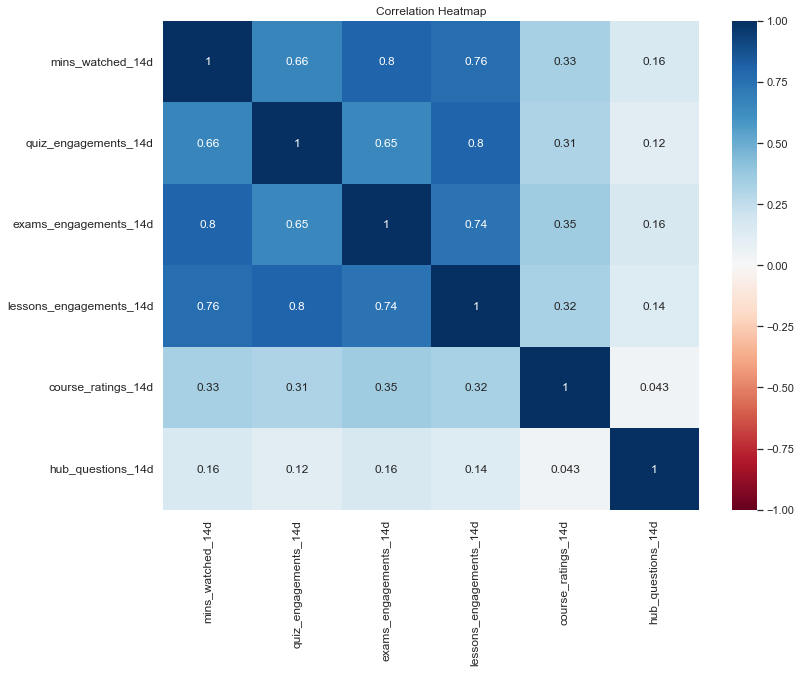

In [4]:
# Correlation between features
plt.figure(figsize = (12,9))
s = sns.heatmap(data[features].corr(),
               annot = True,
               cmap = "RdBu",
               vmin = -1,
               vmax = 1)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 90, fontsize = 12)
plt.title("Correlation Heatmap")
plt.show()

Lot of features seem to correlate with each other. Hence reducing dimensions should be effective in model estimation. 
We shall apply **PCA** to reduce dimenstinality in this case.

### Standardization

In [5]:
scaler = StandardScaler()
data_std = scaler.fit_transform(data[features])

### PCA

In [6]:
pca = PCA()

In [7]:
pca.fit(data_std)

PCA()

In [8]:
pca.explained_variance_ratio_

array([0.57030993, 0.16243626, 0.13574249, 0.0682116 , 0.0343469 ,
       0.02895282])

Text(0, 0.5, 'Cumulative Explianed Variance')

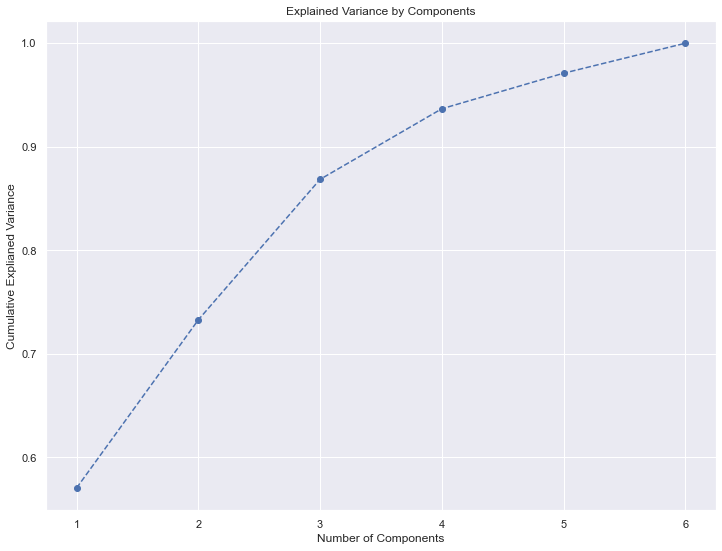

In [9]:
# plotting the observed variance
plt.figure(figsize = (12,9))
plt.plot(range(1,7),pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explianed Variance')

Almost 90% variance is explained by 3 PCs hence we will run PCA with 3 components.

In [10]:
pca = PCA(n_components = 3)

In [11]:
pca.fit(data_std)

PCA(n_components=3)

In [12]:
# understanding the correlation of the PCA loadings against the features
df_pca_comp = pd.DataFrame(data = pca.components_,
                          columns = data[features].columns.values,
                          index = ['Component 1', 'Component 2', 'Component 3'])
df_pca_comp

,mins_watched_14d,quiz_engagements_14d,exams_engagements_14d,lessons_engagements_14d,course_ratings_14d,hub_questions_14d
Component 1,0.481486,0.461824,0.479775,0.491877,0.262006,0.118808
Component 2,-0.008939,-0.063334,-0.002627,-0.038560,-0.234272,0.969295
Component 3,-0.118180,-0.182314,-0.080805,-0.181112,0.933468,0.205187


([<matplotlib.axis.YTick at 0x1f4f1fb6490>,
 [Text(0, 0, 'Component 1'),
  Text(0, 1, 'Component 2'),
  Text(0, 2, 'Component 3')])

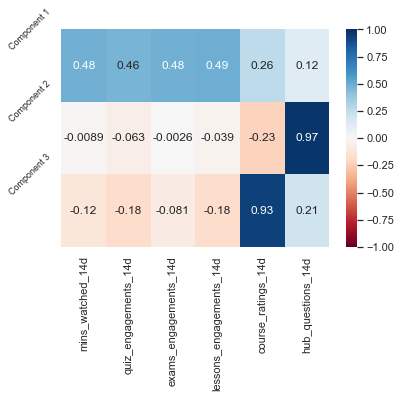

In [13]:
# visualized
sns.heatmap(df_pca_comp,
           vmin = -1,
           vmax = 1,
           cmap = 'RdBu',
           annot = True)
plt.yticks([0,1,2],
          ['Component 1', 'Component 2', 'Component 3'],
          rotation = 45,
          fontsize = 9)

We can see here that the first component explains data variablity from most of content consumption variables like lessons, course and exams watched. Second and third component covers number of questions asked and course ratings respectively. 

In [14]:
scores_pca = pca.transform(data_std)

In [15]:
# adding pca components to the features dataset 
data_pca = pd.concat([data[features].reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
data_pca.columns.values[-3: ] = ['Component 1','Component 2','Component 3']
data_pca.head()

,mins_watched_14d,quiz_engagements_14d,exams_engagements_14d,lessons_engagements_14d,course_ratings_14d,hub_questions_14d,Component 1,Component 2,Component 3
0,0.3,0,0,1,0.0,0,-0.410164,0.015975,-0.048187
1,0.0,0,0,0,0.0,0,-0.704981,0.038991,0.060169
2,268.4,6,3,10,0.0,0,8.295016,-0.603188,-2.771635
3,0.0,0,0,0,0.0,0,-0.704981,0.038991,0.060169
4,0.0,0,0,0,0.0,0,-0.704981,0.038991,0.060169


In [16]:
# Finally we will create 2 data frames each for PCA components and actual features for modelling and comparision
pca_comp = data_pca.drop(columns=['mins_watched_14d','quiz_engagements_14d','exams_engagements_14d','lessons_engagements_14d','course_ratings_14d','hub_questions_14d']).columns
df_pca = pd.concat([data_pca[pca_comp].reset_index(drop = True), data['reg_status']], axis = 1)
df_pca.head()

,Component 1,Component 2,Component 3,reg_status
0,-0.410164,0.015975,-0.048187,0
1,-0.704981,0.038991,0.060169,0
2,8.295016,-0.603188,-2.771635,1
3,-0.704981,0.038991,0.060169,0
4,-0.704981,0.038991,0.060169,0


In [17]:
df = pd.concat([data_pca[features].reset_index(drop = True), data['reg_status']], axis = 1)
df.head()

,mins_watched_14d,quiz_engagements_14d,exams_engagements_14d,lessons_engagements_14d,course_ratings_14d,hub_questions_14d,reg_status
0,0.3,0,0,1,0.0,0,0
1,0.0,0,0,0,0.0,0,0
2,268.4,6,3,10,0.0,0,1
3,0.0,0,0,0,0.0,0,0
4,0.0,0,0,0,0.0,0,0


## Train / Test Split

In [18]:
# splitting pca data
random_seed = 365
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(df_pca[pca_comp], df_pca['reg_status'], test_size=0.2, random_state=random_seed)

In [19]:
print(X_pca_train.shape)
print(X_pca_test.shape)
print(y_pca_train.shape)
print(y_pca_test.shape)
print(y_pca_train.value_counts(normalize=True))
print(y_pca_test.value_counts(normalize=True))

(28184, 3)
(7046, 3)
(28184,)
(7046,)
0    0.938902
1    0.061098
Name: reg_status, dtype: float64
0    0.941385
1    0.058615
Name: reg_status, dtype: float64


In [20]:
# splitting features data
X_train, X_test, y_train, y_test = train_test_split(df[features], df['reg_status'], test_size=0.2, random_state=random_seed)

In [21]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

(28184, 6)
(7046, 6)
(28184,)
(7046,)
0    0.938902
1    0.061098
Name: reg_status, dtype: float64
0    0.941385
1    0.058615
Name: reg_status, dtype: float64


We can notice that the subscription target variable is highly imbalanced, hence we will have to balance the training set. We will leave the testing set as is as we would like to test our models with imbalanced observations. This is how we expect prediction obervations to come by in real life scenario.

## Handling Imbalance

In [22]:
# for pca training set
smote_tomek = SMOTETomek(random_state=42)
X_pca_res, y_pca_res = smote_tomek.fit_resample(X_pca_train, y_pca_train)
y_pca_res.value_counts()

0    25900
1    25900
Name: reg_status, dtype: int64

In [23]:
# for features training set
smote_tomek = SMOTETomek(random_state=42)
X_res, y_res = smote_tomek.fit_resample(X_train, y_train)
y_res.value_counts()

0    26300
1    26300
Name: reg_status, dtype: int64

## Data Modelling

We will use a dictionary and a list to continuously store the results of our experiments and show them as a pandas dataframe.

In [25]:
# as pointed out earlier, our evaluation criteria would be best recall
index = []
scores = {"Recall": []}

### Logistic Regression

In [24]:
lg = LogisticRegression(random_state = 42)

In [27]:
param_grid = { 
    'penalty': ['l2', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'sag', 'saga'],
}

CV_lg = GridSearchCV(estimator=lg, param_grid=param_grid, cv= 5, scoring='recall')
CV_lg.fit(X_res, y_res)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'penalty': ['l2', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             scoring='recall')

In [28]:
CV_lg.best_params_

{'penalty': 'l2', 'solver': 'saga'}

In [29]:
lg1=LogisticRegression(random_state=42, penalty='l2', solver = 'saga')
lg1.fit(X_res, y_res)

LogisticRegression(random_state=42, solver='saga')

In [30]:
test_prob_lg = lg1.predict_proba(X_test)[:, 1]
test_pred_lg = lg1.predict(X_test)

In [31]:
index += ["Logistic regression"]
scores["Recall"].append(recall_score(y_test, test_pred_lg))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Recall
Logistic regression,0.774818


### Logistic Regresion on PCA components

In [32]:
lgpca = LogisticRegression(random_state = 42)

In [34]:
param_grid = { 
    'penalty': ['l2', 'none'],
    'solver' : ['newton-cg', 'lbfgs', 'sag', 'saga'],
}

CV_lgpca = GridSearchCV(estimator=lgpca, param_grid=param_grid, cv= 5, scoring='recall')
CV_lgpca.fit(X_pca_res, y_pca_res)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'penalty': ['l2', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             scoring='recall')

In [35]:
CV_lgpca.best_params_

{'penalty': 'l2', 'solver': 'newton-cg'}

In [36]:
lgpca1=LogisticRegression(random_state=42, penalty='l2', solver = 'newton-cg')
lgpca1.fit(X_pca_res, y_pca_res)

LogisticRegression(random_state=42, solver='newton-cg')

In [37]:
test_prob_lgpca = lgpca1.predict_proba(X_pca_test)[:, 1]
test_pred_lgpca = lgpca1.predict(X_pca_test)

In [38]:
index += ["Logistic regression with PCA"]
scores["Recall"].append(recall_score(y_test, test_pred_lgpca))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Recall
Logistic regression,0.774818
Logistic regression with PCA,0.673123


### Random Forest

In [39]:
rfc = RandomForestClassifier(random_state=42)

In [40]:
param_grid = { 
    'n_estimators': [10, 100],
    'max_features': ['sqrt', 'log2'],
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, scoring='recall')
CV_rfc.fit(X_res, y_res)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 100]},
             scoring='recall')

In [41]:
CV_rfc.best_params_

{'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 100}

In [42]:
rfc1=RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators= 100, criterion='entropy')
rfc1.fit(X_res, y_res)

RandomForestClassifier(criterion='entropy', random_state=42)

In [43]:
test_prob_rfc = rfc1.predict_proba(X_test)[:, 1]
test_pred_rfc = rfc1.predict(X_test)

In [44]:
index += ["Random Forest"]
scores["Recall"].append(recall_score(y_test, test_pred_rfc))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Recall
Logistic regression,0.774818
Logistic regression with PCA,0.673123
Random Forest,0.588378


### Random Forest with PCA

In [45]:
rfcpca = RandomForestClassifier(random_state=42)

In [46]:
param_grid = { 
    'n_estimators': [10, 100],
    'max_features': ['sqrt', 'log2'],
    'criterion' :['gini', 'entropy']
}

CV_rfcpca = GridSearchCV(estimator=rfcpca, param_grid=param_grid, cv= 5, scoring='recall')
CV_rfcpca.fit(X_pca_res, y_pca_res)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 100]},
             scoring='recall')

In [47]:
CV_rfcpca.best_params_

{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100}

In [48]:
rfcpca1=RandomForestClassifier(random_state=42, max_features='sqrt', n_estimators= 100, criterion='gini')
rfcpca1.fit(X_pca_res, y_pca_res)

RandomForestClassifier(random_state=42)

In [49]:
test_prob_rfcpca = rfcpca1.predict_proba(X_pca_test)[:, 1]
test_pred_rfcpca = rfcpca1.predict(X_pca_test)

In [50]:
index += ["Random Forest with PCA"]
scores["Recall"].append(recall_score(y_test, test_pred_rfcpca))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Recall
Logistic regression,0.774818
Logistic regression with PCA,0.673123
Random Forest,0.588378
Random Forest with PCA,0.617433


### Histogram Gradient Boosting

In [51]:
hgb = HistGradientBoostingClassifier(random_state=42)

In [52]:
param_grid = { 
    'loss': ['log_loss', 'auto', 'binary_crossentropy', 'categorical_crossentropy'],
    'learning_rate': [0.1,0.5]
}

CV_hgb = GridSearchCV(estimator=hgb, param_grid=param_grid, cv= 5, scoring='recall')
CV_hgb.fit(X_res, y_res)

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [0.1, 0.5],
                         'loss': ['log_loss', 'auto', 'binary_crossentropy',
                                  'categorical_crossentropy']},
             scoring='recall')

In [53]:
CV_hgb.best_params_

{'learning_rate': 0.5, 'loss': 'log_loss'}

In [54]:
hgb1=HistGradientBoostingClassifier(random_state=42, learning_rate = 0.5, loss = 'log_loss')
hgb1.fit(X_res, y_res)

HistGradientBoostingClassifier(learning_rate=0.5, random_state=42)

In [56]:
test_prob_hgb = hgb1.predict_proba(X_test)[:, 1]
test_pred_hgb = hgb1.predict(X_test)

In [57]:
index += ["Histogram Gradient Boosting"]
scores["Recall"].append(recall_score(y_test, test_pred_hgb))
df_scores = pd.DataFrame(scores, index=index)
df_scores

,Recall
Logistic regression,0.774818
Logistic regression with PCA,0.673123
Random Forest,0.588378
Random Forest with PCA,0.617433
Histogram Gradient Boosting,0.644068


## Final Model

Based on evaluation criteria (Recall), we have Logistic Regression as the winner. We will review other performance metrics of the model here.

In [58]:
# Logistic Regression
test_prob = lg1.predict_proba(X_test)[:, 1]
test_pred = lg1.predict(X_test)

In [59]:
print('Log loss = {:.5f}'.format(log_loss(y_test, test_prob)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, test_prob)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, test_pred)))
print('Precision = {:.5f}'.format(precision_score(y_test, test_pred)))
print('Recall = {:.5f}'.format(recall_score(y_test, test_pred)))
print('F1 score = {:.5f}'.format(f1_score(y_test, test_pred)))

print('\nClassification Report')
print(classification_report(y_test, test_pred))

Log loss = 0.72624
AUC = 0.84547
Average Precision = 0.47312

Using 0.5 as threshold:
Accuracy = 0.80443
Precision = 0.19938
Recall = 0.77482
F1 score = 0.31715

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.81      0.89      6633
           1       0.20      0.77      0.32       413

    accuracy                           0.80      7046
   macro avg       0.59      0.79      0.60      7046
weighted avg       0.94      0.80      0.85      7046



### Confusion Matrix

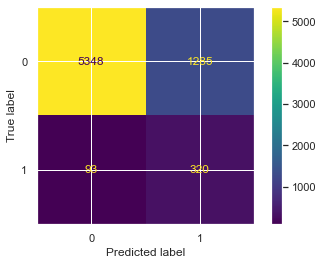

In [60]:
cm = confusion_matrix(y_test, test_pred, labels=lg1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lg1.classes_)
disp.plot()

### Interpretation of coefficients

In [61]:
coefficients = np.hstack((lg1.intercept_, lg1.coef_[0]))
pd.DataFrame(data={'variable': ['intercept'] + ['mins_watched_14d', 'quiz_engagements_14d', 'exams_engagements_14d',
       'lessons_engagements_14d', 'course_ratings_14d', 'hub_questions_14d'] , 'coefficient': coefficients})

,variable,coefficient
0,intercept,-0.121087
1,mins_watched_14d,0.015993
2,quiz_engagements_14d,0.016554
3,exams_engagements_14d,-0.002039
4,lessons_engagements_14d,-0.011848
5,course_ratings_14d,-0.003915
6,hub_questions_14d,-0.000654


## Conclusion

**Our analysis shows that Logistic Regression is the most effective model for this data if we want to optimize for low false negatives (high recall). It's important to note that the model of choice might have changed if we would have wanted to optimize for other performance metrics like accuracy or even F1 score which considers both precision and recall. 
Our exercise also demonstrate the importance of hyperparameter tuning. We see that logistic regression results would have been very different if we would have gone with default solver or something other than 'saga'. This solver is more lenient compared to others which means higher false positives but low false negatives.
This also highlights flexiblity of logistic regression compared to trees based models like random forest. Random forest would always be more accurate but less effective when we want to optimize for recall or precision.**